In [62]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import bokeh.plotting as bpl
import cv2
import glob
import logging
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')
import numpy as np
import os
import pickle
from custom_functions import loadmat

try:
    cv2.setNumThreads(0)
except():
    pass

try:
    if __IPYTHON__:
        # this is used for debugging purposes only. allows to reload classes
        # when changed
        get_ipython().magic('load_ext autoreload')
        get_ipython().magic('autoreload 2')
except NameError:
    pass

import caiman as cm
from caiman.motion_correction import MotionCorrect
from caiman.source_extraction.cnmf import cnmf as cnmf
from caiman.source_extraction.cnmf import params as params
from caiman.utils.utils import download_demo
from caiman.utils.visualization import plot_contours, nb_view_patches, nb_plot_contour
bpl.output_notebook()

import matplotlib as mpl
mpl.rcParams.update({
    'figure.figsize': (18, 13),
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [ ]:
#%% start a cluster for parallel processing (if a cluster already exists it will be closed and a new session will be opened)
if 'dview' in locals():
    cm.stop_server(dview=dview)
c, dview, n_processes = cm.cluster.setup_cluster(
    backend='local', n_processes=None, single_thread=False)

In [ ]:
# filename = '//duhs-user-nc1.dhe.duke.edu/dusom_glickfeldlab/All_Staff/home/lan/Data/2P_images/i1329/201209/002/caiman_002_vertical.hdf5'
# filename = '//duhs-user-nc1.dhe.duke.edu/dusom_glickfeldlab/All_Staff/home/lan/Data/2P_images/i1329/201209/002/caiman_002_1200_eval.hdf5'
filename = 'caiman_002_full.hdf5'
cnm = cnmf.load_CNMF(filename, n_processes=n_processes, dview=dview)

In [ ]:
mmap_name = '//duhs-user-nc1.dhe.duke.edu/dusom_glickfeldlab/All_Staff/home/lan/Data/2P_images/\
i1329/201209/002/002_vertical_els__d1_796_d2_264_d3_1_order_F_frames_1200_.mmap'
Yr, dims, T = cm.load_memmap(mmap_name)
images = np.reshape(Yr.T, [T] + list(dims), order='F') 

Cn = cm.local_correlations(images.transpose(1,2,0))
Cn[np.isnan(Cn)] = 0

# Component eval

In [ ]:
def caiman_reasoning(idx_list, is_cell, sort_by, save_flag):

    import pylab as pl
    from caiman.base.rois import com
    from caiman.utils.visualization import plot_contours, get_contours
    from post_analysis import check_eval_results_LL

    for component_id in idx_list:
        snr, rval, cnn = check_eval_results_LL(cnm, [component_id], print_score=False)
#         if (rval >= r_max) and (snr < snr_max) and (cnn < cnn_max):

        crd = plot_contours_LL(cnm.estimates.A[:, component_id], Cn, thr=0.9, display_numbers=False);
        plt.clf()
        plt.figure()

        ypos = np.floor(crd[0]['CoM']).astype(int)[0] # y position of caiman segmented cell's center of mass
        proximity_range = 50 # plot how many pixels around CoM
        Cn_chunk = Cn[max(ypos-proximity_range, 0):min(ypos+proximity_range, Cn.shape[0]), :] # do not exceed Cn nrow
        plt.imshow(Cn_chunk)

        crd_converted = crd[0]['coordinates'].copy()
        crd_converted[:,1] = crd_converted[:,1] - max(ypos-proximity_range, 0) # origin (0 position) shifting due to edge
        pl.plot(*crd_converted.T, color='red', alpha=1)

        snr_min = cnm.params.quality['SNR_lowest']
        snr_max = cnm.params.quality['min_SNR']
        r_min = cnm.params.quality['rval_lowest']
        r_max = cnm.params.quality['rval_thr']
        cnn_min = cnm.params.quality['cnn_lowest']
        cnn_max = cnm.params.quality['min_cnn_thr']

        color_snr = 'black'
        if snr < snr_min: color_snr = 'red';
        elif snr >= snr_max: color_snr = 'green';
        color_rval = 'black'
        if rval < r_min: color_rval = 'red';
        elif rval >= r_max: color_rval = 'green';
        color_cnn = 'black'
        if cnn < cnn_min: color_cnn = 'red';
        elif cnn >= cnn_max: color_cnn = 'green';

        txt_snr = 'snr = ' + ('%.2f' % snr) + " @ threshold (" + ('%.2f' % snr_min) + ", " + ('%.2f' % snr_max) + ")"
        txt_rval = 'rval = ' + ('%.2f' % rval) + " @ threshold (" + ('%.2f' % r_min) + ", " + ('%.2f' % r_max) + ")"
        txt_cnn = 'cnn = ' + ('%.2f' % cnn) + " @ threshold (" + ('%.2f' % cnn_min) + ", " + ('%.2f' % cnn_max) + ")"

        txt_ypos = 0.2
        plt.text(0.4, txt_ypos, txt_snr, fontsize=14, color=color_snr, transform=plt.gcf().transFigure)
        plt.text(0.4, txt_ypos-0.02, txt_rval, fontsize=14, color=color_rval, transform=plt.gcf().transFigure)
        plt.text(0.4, txt_ypos-0.04, txt_cnn, fontsize=14, color=color_cnn, transform=plt.gcf().transFigure);

        if is_cell == True:
            cell_string = '_cell_'
        else:
            cell_string = '_noncell_'
        
        if sort_by == 'snr':
            score_string = 'snr_score_' + str(np.floor(snr*100))
        elif sort_by == 'rval':
            score_string = 'rval_score_' + str(np.floor(rval*100))
        elif sort_by == 'cnn':
            score_string = 'cnn_score_' + str(np.floor(cnn*100))
        else:
            score_string = ''
        
        filename = score_string + cell_string + str(component_id)
        if save_flag == True:
            plt.savefig(filename +'.png', bbox_inches='tight')
            plt.close()

In [ ]:
# caiman_reasoning(cnm.estimates.idx_components, is_cell=True, sort_by=None, save_flag=True)
# caiman_reasoning(cnm.estimates.idx_components_bad, is_cell=False, sort_by=None, save_flag=True)

# Second pass

In [ ]:
def caiman_additional_pass(idx_list, sort_by, save_flag):

    import pylab as pl
    from caiman.base.rois import com
    from caiman.utils.visualization import plot_contours, get_contours
    from caiman.base.rois import extract_binary_masks_blob
    from tqdm import tqdm
    
    pass_arr = []
    for component_id in tqdm(idx_list):
        clear_output(wait=True) # clear warning, otherwise cell output too long
        
        crd = plot_contours(cnm.estimates.A[:, component_id], Cn, thr=0.9, display_numbers=False);
        plt.close()
        
        # aspect ratio should not be extreme
        range0 = np.nanmax(crd[0]['coordinates'][:,0]) - np.nanmin(crd[0]['coordinates'][:,0])
        range1 = np.nanmax(crd[0]['coordinates'][:,1]) - np.nanmin(crd[0]['coordinates'][:,1])
        aspect_ratio = range0 / (range1 + 1e-40)
        aspect_ratio_pass = (aspect_ratio<3) and (aspect_ratio>1/3)
        
        # height & width should not be small
        height_width_pass = (range0>=3) and (range1>=3)
            
        # cell should not only occupy edge space
        edge_radius = 5
        dims = [796, 264]
        edge_pass = ((np.nanmax(crd[0]['coordinates'][:,0])>edge_radius)
                     and (np.nanmin(crd[0]['coordinates'][:,0])<dims[1]-edge_radius)
                     and (np.nanmax(crd[0]['coordinates'][:,1])>edge_radius)
                     and (np.nanmin(crd[0]['coordinates'][:,1])<dims[0]-edge_radius))
            
        # area should not be small
        gSig = [4, 4]
        masks_ws, _, _ = extract_binary_masks_blob(cnm.estimates.A[:, component_id], 
                                                       neuron_radius=gSig[0], dims=[796, 264])
        plt.close()
        area = np.sum(masks_ws)
        area_pass = area>25
        
        pass_flag = aspect_ratio_pass and height_width_pass and edge_pass and area_pass
        pass_arr = np.concatenate((pass_arr, pass_flag), axis=None)
        
        # plot cell & explain reasoning
        plt.clf()
        plt.figure()

        ypos = np.floor(crd[0]['CoM']).astype(int)[0] # y position of caiman segmented cell's center of mass
        proximity_range = 50 # plot how many pixels around CoM
        Cn_chunk = Cn[max(ypos-proximity_range, 0):min(ypos+proximity_range, Cn.shape[0]), :] # do not exceed Cn nrow
        plt.imshow(Cn_chunk)

        crd_converted = crd[0]['coordinates'].copy()
        crd_converted[:,1] = crd_converted[:,1] - max(ypos-proximity_range, 0) # origin (0 position) shifting due to edge
        pl.plot(*crd_converted.T, color='red', alpha=1)
        
        colors = ['r', 'b'] # false=red, true=black
        txt_ypos = 0.2
        plt.text(0.4, txt_ypos, 'aspect_ratio_pass: ' + str(aspect_ratio_pass) + ' ' + ('%.2f' % aspect_ratio), 
                 fontsize=14, color=colors[int(aspect_ratio_pass)], transform=plt.gcf().transFigure)
        plt.text(0.4, txt_ypos-0.02, 'height_width_pass: ' + str(height_width_pass) + ' ' + ('%.2f' % range0) + ' ' + ('%.2f' % range1),
                 fontsize=14, color=colors[int(height_width_pass)], transform=plt.gcf().transFigure)
        plt.text(0.4, txt_ypos-0.04, 'edge_pass: ' + str(edge_pass), 
                 fontsize=14, color=colors[int(edge_pass)], transform=plt.gcf().transFigure);
        plt.text(0.4, txt_ypos-0.06, 'area_pass: ' + str(area_pass) + ' ' + ('%.2f' % area), 
                 fontsize=14, color=colors[int(area_pass)], transform=plt.gcf().transFigure);

        if sort_by == 'aspect_ratio':
            score_string = 'aspect_ratio_' + str(aspect_ratio_pass)
        elif sort_by == 'height_width':
            score_string = 'height_width_' + str(height_width_pass)
        elif sort_by == 'edge':
            score_string = 'edge_' + str(edge_pass)
        elif sort_by == 'area':
            score_string = 'area_' + str(area_pass)
        else:
            score_string = 'pass_flag_' + str(pass_flag)
        
        filename = score_string + '_' + str(component_id)
        if save_flag == True:
            plt.savefig(filename +'.png', bbox_inches='tight')
            plt.close()
    
    return pass_arr

In [ ]:
pass_arr = caiman_additional_pass(cnm.estimates.idx_components, sort_by=None, save_flag=False)
pass_arr = list(map(bool,pass_arr))

In [47]:
cell_id_passed = cnm.estimates.idx_components[pass_arr]

print('out of %2d cells from caiman, only %2d cells passed secondary criteria: \
area, aspect ratio, height width, edge' 
      % ( len(cnm.estimates.idx_components), len(cnm.estimates.idx_components[pass_arr]) )
     )

out of 686 cells from caiman, only 649 cells passed secondary criteria: area, aspect ratio, height width, edge


## find threshold for area pass

In [ ]:
from caiman.base.rois import extract_binary_masks_blob
from IPython.display import clear_output
gSig = [4, 4]

area_arr = []
for component_id in cnm.estimates.idx_components:
    masks_ws, pos_examples, neg_examples = extract_binary_masks_blob(cnm.estimates.A[:, component_id], 
                                                                 neuron_radius=gSig[0], dims=[796, 264])
    area = np.sum(masks_ws)
    area_arr = np.append(area_arr, area)
    clear_output(wait=True)

(655, 686)

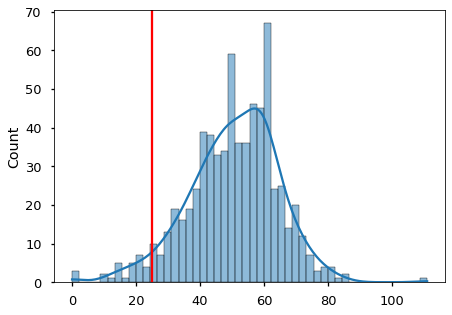

In [55]:
import seaborn as sns
plt.figure(figsize=(7,5))
sns.histplot(area_arr, bins=50, kde=True)
plt.axvline(25, color='r')

sum(area_arr>25), len(area_arr)

# Extract activity

In [56]:
df_cells = cnm.estimates.F_dff[cell_id_passed, :]
df_cells.shape

(649, 100000)

In [ ]:
from scipy.io import savemat
mdic = {"df_cells": df_cells}
savemat("caiman_cell_activity.mat", mdic)

# Compare seg
caiman vs manual 

In [57]:
def plot_contours_LL(A, Cn, thr=None, thr_method='max', maxthr=0.2, nrgthr=0.9, display_numbers=True, max_number=None,
                     cmap=None, swap_dim=False, colors='w', alpha=0.5, linewidth=1.0, swap_background=False,
                     vmin=None, vmax=None, coordinates=None,
                     contour_args={}, number_args={}, **kwargs):
    """Plots contour of spatial components against a background image and returns their coordinates
       LL: added alpha and linewidth

     Args:
         A:   np.ndarray or sparse matrix
                   Matrix of Spatial components (d x K)
    
         Cn:  np.ndarray (2D)
                   Background image (e.g. mean, correlation)
    
         thr_method: [optional] string
                  Method of thresholding:
                      'max' sets to zero pixels that have value less than a fraction of the max value
                      'nrg' keeps the pixels that contribute up to a specified fraction of the energy
    
         maxthr: [optional] scalar
                    Threshold of max value
    
         nrgthr: [optional] scalar
                    Threshold of energy
    
         thr: scalar between 0 and 1
                   Energy threshold for computing contours (default 0.9)
                   Kept for backwards compatibility. If not None then thr_method = 'nrg', and nrgthr = thr
    
         display_number:     Boolean
                   Display number of ROIs if checked (default True)
    
         max_number:    int
                   Display the number for only the first max_number components (default None, display all numbers)
    
         cmap:     string
                   User specifies the colormap (default None, default colormap)

     Returns:
          coordinates: list of coordinates with center of mass, contour plot coordinates and bounding box for each component
    """

    from caiman.utils.visualization import get_contours #, plot_contours
    import pylab as pl

    if swap_dim:
        Cn = Cn.T
        print('Swapping dim')

    if thr is None:
        try:
            thr = {'nrg': nrgthr, 'max': maxthr}[thr_method]
        except KeyError:
            thr = maxthr
    else:
        thr_method = 'nrg'


    for key in ['c', 'colors', 'line_color']:
        if key in kwargs.keys():
            color = kwargs[key]
            kwargs.pop(key)

    ax = pl.gca()
    if swap_background == False:
        if vmax is None and vmin is None:
            pl.imshow(Cn, interpolation=None, cmap=cmap,
                      vmin=np.percentile(Cn[~np.isnan(Cn)], 1),
                      vmax=np.percentile(Cn[~np.isnan(Cn)], 99))
        else:
            pl.imshow(Cn, interpolation=None, cmap=cmap, vmin=vmin, vmax=vmax)

    if coordinates is None:
        coordinates = get_contours(A, np.shape(Cn), thr, thr_method, swap_dim)
    for c in coordinates:
        v = c['coordinates']
        c['bbox'] = [np.floor(np.nanmin(v[:, 1])), np.ceil(np.nanmax(v[:, 1])),
                     np.floor(np.nanmin(v[:, 0])), np.ceil(np.nanmax(v[:, 0]))]
        pl.plot(*v.T, c=colors, alpha=alpha, linewidth=linewidth, **contour_args)

    if display_numbers:
        d1, d2 = np.shape(Cn)
        d, nr = np.shape(A)
        cm = com(A, d1, d2)
        if max_number is None:
            max_number = A.shape[1]
        for i in range(np.minimum(nr, max_number)):
            if swap_dim:
                ax.text(cm[i, 0], cm[i, 1], str(i + 1), color=colors, **number_args)
            else:
                ax.text(cm[i, 1], cm[i, 0], str(i + 1), color=colors, **number_args)
    return coordinates

## contour on caiman corr_img

In [60]:
cell_id_passed = cnm.estimates.idx_components[pass_arr]
cell_id_passed[:10], cell_id_passed[-10:], len(cell_id_passed)

(array([ 0,  6,  7,  8, 10, 16, 17, 22, 36, 39]),
 array([1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063]),
 649)

In [ ]:
for cell_id in cell_id_passed:
    _ = plot_contours_LL(cnm.estimates.A[:, cell_id], Cn, thr=0.9, alpha=0.5, linewidth=1, display_numbers=False);
plt.title('caiman_cell_background_corr', pad=20)
plt.savefig('caiman_cell_background_corr.pdf', format='pdf', bbox_inches='tight')

In [ ]:
cell_id_failed = np.hstack((cnm.estimates.idx_components_bad, 
                            cnm.estimates.idx_components[~np.array(pass_arr)]))
# len(cell_id_failed), len(cnm.estimates.idx_components_bad)

for cell_id in cell_id_failed:
    _ = plot_contours_LL(cnm.estimates.A[:, cell_id], Cn, thr=0.9, alpha=0.5, linewidth=1, display_numbers=False);
plt.title('caiman_noncell_background_corr', pad=20)
plt.savefig('caiman_noncell_background_corr.pdf', format='pdf', bbox_inches='tight')

## max proj & top perc

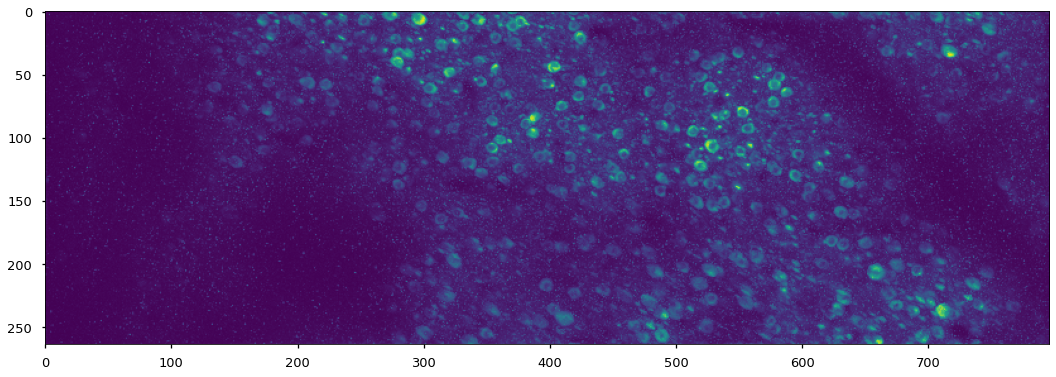

In [64]:
mat = 'Z:/All_Staff/home/lan/Analysis/2P/201209_i1329/201209_i1329_runs-002/data_max.mat'
t = loadmat(mat)

data_max_projection = t['data_max_projection']
data_top_perc = t['data_top_perc']

plt.imshow(data_max_projection)
# plt.imshow(data_top_perc)

In [ ]:
for cell_id in cell_id_passed:
    _ = plot_contours_LL(cnm.estimates.A[:, cell_id], Cn, thr=0.9, colors='w',
                         alpha=0.5, linewidth=1, swap_background=True, display_numbers=False);
# plt.imshow(seg_ref.T);
plt.imshow(data_max_projection.T)

plt.title('caiman_cell_background_max_proj', pad=20)
plt.savefig('caiman_cell_background_max_proj.pdf', format='pdf', bbox_inches='tight')

In [ ]:
for cell_id in cell_id_passed:
    _ = plot_contours_LL(cnm.estimates.A[:, cell_id], Cn, thr=0.9, colors='w',
                         alpha=0.5, linewidth=1, swap_background=True, display_numbers=False);
plt.imshow(data_top_perc.T)

plt.title('caiman_cell_background_top_perc', pad=20)
plt.savefig('caiman_cell_background_top_perc.pdf', format='pdf', bbox_inches='tight')

## manual

In [65]:
mat = 'Z:/All_Staff/home/lan/Analysis/2P/201209_i1329/201209_i1329_runs-002/201209_i1329_runs-002_mask_cell_addfake.mat'
t = loadmat(mat)
t['mask_cell'].shape, np.max(t['mask_cell'])

((264, 796), 146)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146], dtype=uint8)

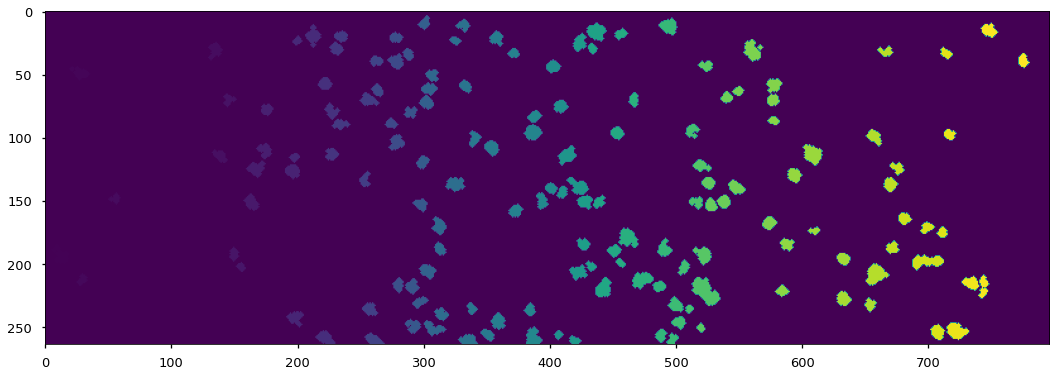

In [66]:
plt.imshow(t['mask_cell'])
np.unique(t['mask_cell'])

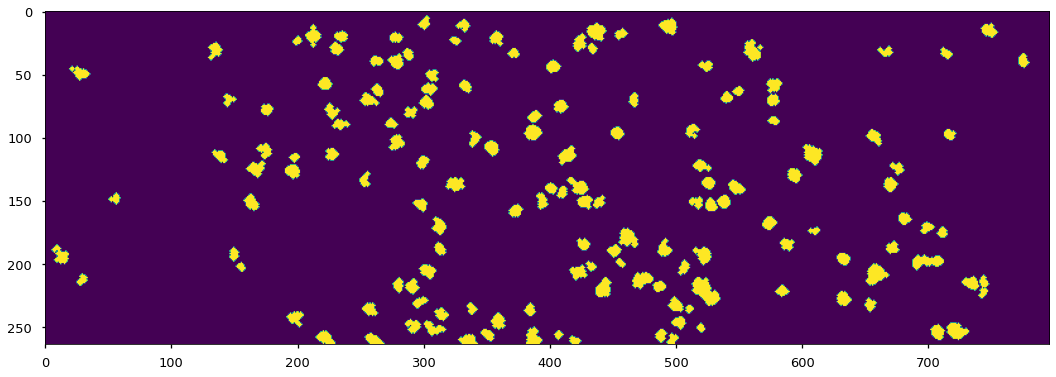

In [67]:
seg_ref = t['mask_cell'].copy()
sz = seg_ref.shape

seg_ref = seg_ref.flatten()
seg_ref[seg_ref>1] = 1
seg_ref = seg_ref.reshape(sz)

plt.imshow(seg_ref)

In [ ]:
for cell_id in cell_id_passed:
    _ = plot_contours_LL(cnm.estimates.A[:, cell_id], Cn, thr=0.9, colors='r',
                         alpha=0.5, linewidth=1, swap_background=True, display_numbers=False);
plt.imshow(seg_ref.T);

plt.title('compare_caiman_vs_manual', pad=20)
plt.savefig('compare_caiman_vs_manual_loose.pdf', format='pdf', bbox_inches='tight')
# 12 cells included in manual but not in caiman

In [ ]:
for cell_id in cell_id_failed:
    _ = plot_contours_LL(cnm.estimates.A[:, cell_id], Cn, thr=0.9, colors='r',
                         alpha=0.5, linewidth=1, swap_background=True, display_numbers=False);
plt.imshow(seg_ref.T);

plt.title('compare_caiman_noncell_vs_manual', pad=20)
plt.savefig('compare_caiman_bad_vs_manual_loose.pdf', format='pdf', bbox_inches='tight')
# 6/12 cells were categorized as "bad" by caiman, the remaining 6 are maybe missing

## suboptimal comparison method

In [ ]:
# compare caiman max correlation img vs manual segmentation (strict, but wrong time window for Ca transient)
corr_caiman = Cn.T

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# get colormap
ncolors = 256
color_array = plt.get_cmap('gist_rainbow')(range(ncolors))
# change alpha values
color_array[:,-1] = np.linspace(1.0,0.0,ncolors)
# create a colormap object
map_object = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)
# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

im1 = plt.imshow(corr_caiman, cmap='rainbow_alpha', alpha=1)
im2 = plt.imshow(seg_ref, cmap='Blues', alpha=0.4)
plt.show()

In [ ]:
# use manual segmentation (blind, less strict)
corr_caiman = Cn.T
im1 = plt.imshow(corr_caiman, cmap='rainbow_alpha', alpha=1)
im2 = plt.imshow(seg_ref, cmap='Blues', alpha=0.4)
plt.show()

# Compare good cell map
compare caiman full tif vs manual, with cell vis criteria

## using only vis driven cells 

In [98]:
# code\py_playground\vis_cell_manual_vs_caiman.pckl
root_path = 'C:/Users/ll357/Documents/inter/'
pickle_file = os.path.join(root_path, 'code/py_playground/vis_cell_manual_vs_caiman.pckl')

f = open(pickle_file, 'rb')
vis_id_manual, vis_id_caiman_0 = pickle.load(f)
f.close()

Text(0.5, 1.0, 'compare_caiman_vs_manual, vis-driven only')

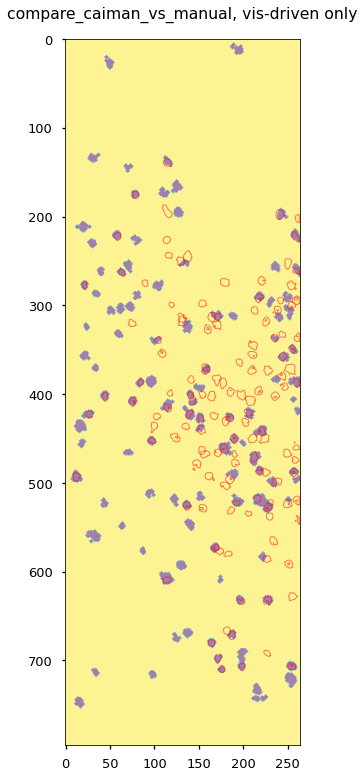

In [100]:
seg_manual_vis = t['mask_cell'].copy()
id_mask = np.isin(seg_manual_vis, vis_id_manual)
seg_manual_vis[id_mask == False] = 0
seg_manual_vis[seg_manual_vis>0] = 1

seg_manual_vis[seg_manual_vis==1] = 2
seg_manual_vis[seg_manual_vis==0] = 1
seg_manual_vis[seg_manual_vis==2] = 0

cell_id_passed_vis_thres = cell_id_passed[vis_id_caiman_0]
for cell_id in cell_id_passed_vis_thres:
    _ = plot_contours_LL(cnm.estimates.A[:, cell_id], Cn, thr=0.9, colors='r',
                         alpha=0.5, linewidth=1, swap_background=True, display_numbers=False);
plt.imshow(seg_manual_vis.T, alpha=0.5);

plt.title('compare_caiman_vs_manual, vis-driven only', pad=20)
# plt.savefig('compare_caiman_vs_manual_post.pdf', format='pdf', bbox_inches='tight')

## using only vis driven cells after dfof_ad thresholding

In [72]:
cell_id_passed = cnm.estimates.idx_components[pass_arr]
cell_id_passed[:10], cell_id_passed[-10:], len(cell_id_passed)

(array([ 0,  6,  7,  8, 10, 16, 17, 22, 36, 39]),
 array([1054, 1055, 1056, 1057, 1058, 1059, 1060, 1061, 1062, 1063]),
 649)

(0, 146)

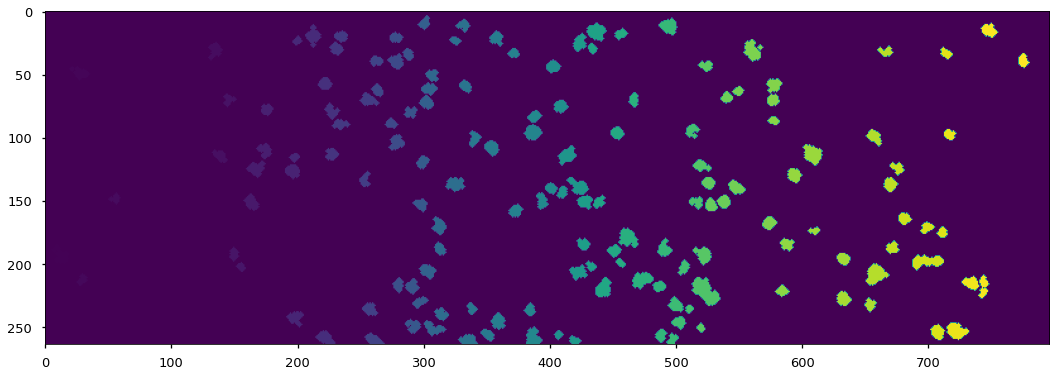

In [69]:
plt.imshow(t['mask_cell'])
np.unique(t['mask_cell']).min(), np.unique(t['mask_cell']).max()

In [77]:
# code\py_playground\vis_cell_manual_vs_caiman.pckl
root_path = 'C:/Users/ll357/Documents/inter/'
pickle_file = os.path.join(root_path, 'code/py_playground/vis_cell_manual_vs_caiman.pckl')

f = open(pickle_file, 'rb')
vis_id_manual, vis_id_caiman_0 = pickle.load(f)
f.close()

(array([  5,   7,  12,  13,  14,  15,  18,  19,  21,  23,  26,  28,  30,
         31,  34,  35,  37,  38,  39,  40,  42,  49,  50,  51,  52,  53,
         57,  58,  59,  60,  62,  64,  65,  66,  67,  68,  69,  70,  71,
         72,  73,  74,  75,  76,  80,  81,  82,  84,  86,  87,  88,  89,
         90,  91,  93,  95,  96,  97,  98,  99, 100, 103, 105, 106, 107,
        110, 111, 115, 116, 117, 120, 123, 124, 125, 126, 134, 136, 137,
        138, 139, 143, 145], dtype=int64),
 array([ 99, 104, 118, 127, 135, 142, 144, 146, 151, 162, 168, 169, 170,
        175, 176, 177, 178, 179, 181, 186, 187, 188, 189, 190, 192, 199,
        200, 201, 203, 209, 211, 217, 220, 221, 222, 244, 251, 252, 254,
        283, 300, 332, 345, 346, 395, 396, 401, 403, 404, 408, 426, 427,
        430, 438, 447, 457, 464, 466, 472, 473, 481, 485, 492, 503, 513,
        514, 526, 527, 537, 538, 540, 541, 549, 550, 560, 574, 580, 581,
        584, 585, 593, 599, 615, 622, 623, 627, 632, 639, 647, 648],
       dtype

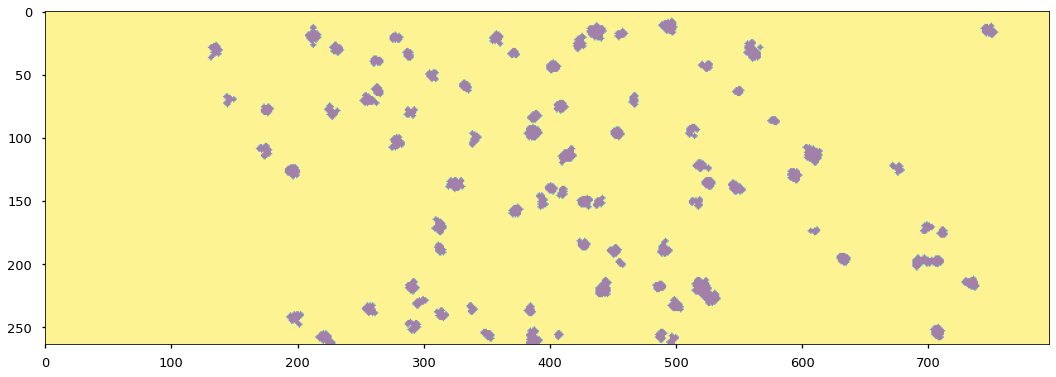

In [92]:
seg_manual_vis = t['mask_cell'].copy()
id_mask = np.isin(seg_manual_vis, vis_id_manual)
seg_manual_vis[id_mask == False] = 0
seg_manual_vis[seg_manual_vis>0] = 1

seg_manual_vis[seg_manual_vis==1] = 2
seg_manual_vis[seg_manual_vis==0] = 1
seg_manual_vis[seg_manual_vis==2] = 0

plt.imshow(seg_manual_vis, alpha=0.5)
# plt.imshow(t['mask_cell'])

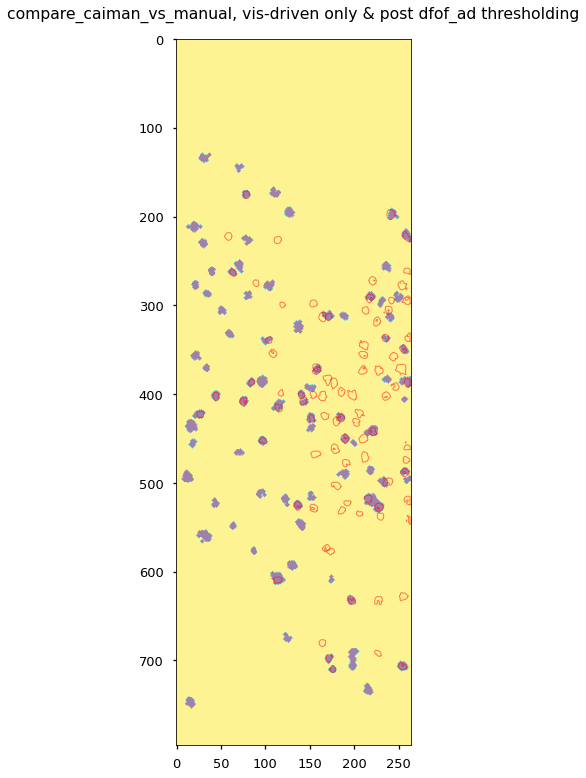

In [93]:
cell_id_passed_vis_thres = cell_id_passed[vis_id_caiman_0]

for cell_id in cell_id_passed_vis_thres:
    _ = plot_contours_LL(cnm.estimates.A[:, cell_id], Cn, thr=0.9, colors='r',
                         alpha=0.5, linewidth=1, swap_background=True, display_numbers=False);
plt.imshow(seg_manual_vis.T, alpha=0.5);

plt.title('compare_caiman_vs_manual, vis-driven only & post dfof_ad thresholding', pad=20)
plt.savefig('compare_caiman_vs_manual_post_analysis.pdf', format='pdf', bbox_inches='tight')

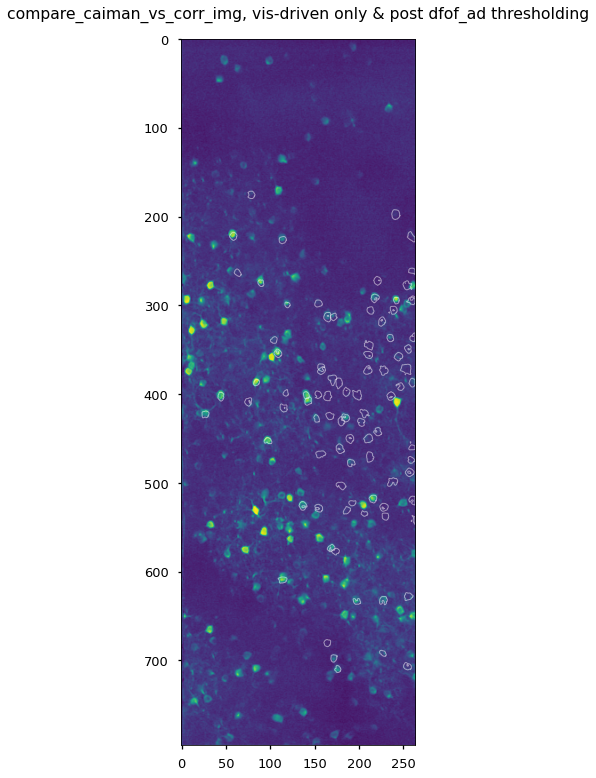

In [97]:
for cell_id in cell_id_passed_vis_thres:
    _ = plot_contours_LL(cnm.estimates.A[:, cell_id], Cn, thr=0.9, colors='w',
                         alpha=0.5, linewidth=1, swap_background=True, display_numbers=False);

plt.imshow(Cn)

plt.title('compare_caiman_vs_corr_img, vis-driven only & post dfof_ad thresholding', pad=20)
plt.savefig('compare_caiman_vs_corr_img_post_analysis.pdf', format='pdf', bbox_inches='tight')